## Make a normalized embedded object of the HLCA core + Meyer_2021 data after mapping with scArches and cluster

Here we generate a separate HLCA core + Meyer_2021 data object, including a UMAP, clustering, and normalized data.

### Import modules, set paths:

Modules:

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import anndata as ad
from scipy import sparse

sys.path.append(f"../../scripts")
import nested_clustering

For pretty code formatting (not needed to run code):

In [2]:
%load_ext lab_black

Paths:

In [3]:
path_atlas_extension_embedding = "../../data/HLCA_extended/HLCA_extended/HLCA_extended_scarches_emb.h5ad"  # for up-to-date metadata meyer
path_HLCA_core = "../../data/HLCA_core_h5ads/HLCA_v2.h5ad"
path_meyer_counts = (
    "../../data/HLCA_extended/extension_datasets/ready/full/meyer_2021.h5ad"
)
path_label_transfer = (
    "../../results/HLCA_ext_label_transfer/transfered_labels_query_only.csv"
)
path_output_core_meyer_adata = "../../data/HLCA_extended/HLCA_core_plus_single_study/HLCA_meyer_2021_adata_full_tcnorm_log1p.h5ad"

Load files:

In [4]:
adata_core = sc.read_h5ad(path_HLCA_core)
adata_meyer = sc.read_h5ad(path_meyer_counts)
adata_ext_emb = sc.read_h5ad(path_atlas_extension_embedding)
label_tr_res = pd.read_csv(path_label_transfer, index_col=0)

Set figure parameters:

In [5]:
sc.set_figure_params(dpi=100, figsize=(4, 4))

### Combine core, meyer_2021, and latent embedding:

Make indices match: add a suffix to the raw data indices

In [6]:
new_index = [f"{idx}_meyer_unpubl" for idx in adata_meyer.obs.index]

In [7]:
if not adata_meyer.obs.index[0].endswith("_meyer_unpubl"):
    adata_meyer.obs.index = new_index

check if all indices match now:

In [8]:
adata_meyer.obs.index.isin(adata_ext_emb.obs.index).sum() == adata_meyer.n_obs

True

add embedding to meyer raw:

In [9]:
adata_meyer.obsm["X_scanvi_emb"] = adata_ext_emb[adata_meyer.obs.index, :].X

copy .obs from embedding object (this has cleaner metadata):

In [10]:
adata_meyer.obs = adata_ext_emb.obs.loc[adata_meyer.obs.index, :]

remove unused categories from categoricals:

In [11]:
for col in adata_meyer.obs.columns:
    if adata_meyer.obs[col].dtype.name == "category":
        adata_meyer.obs[col] = adata_meyer.obs[col].cat.remove_unused_categories()

check if counts are raw (wait for final confirmation Elo, these counts are souped and therefore not integers):

In [12]:
total_counts_raw = adata_meyer.X.sum(axis=1)

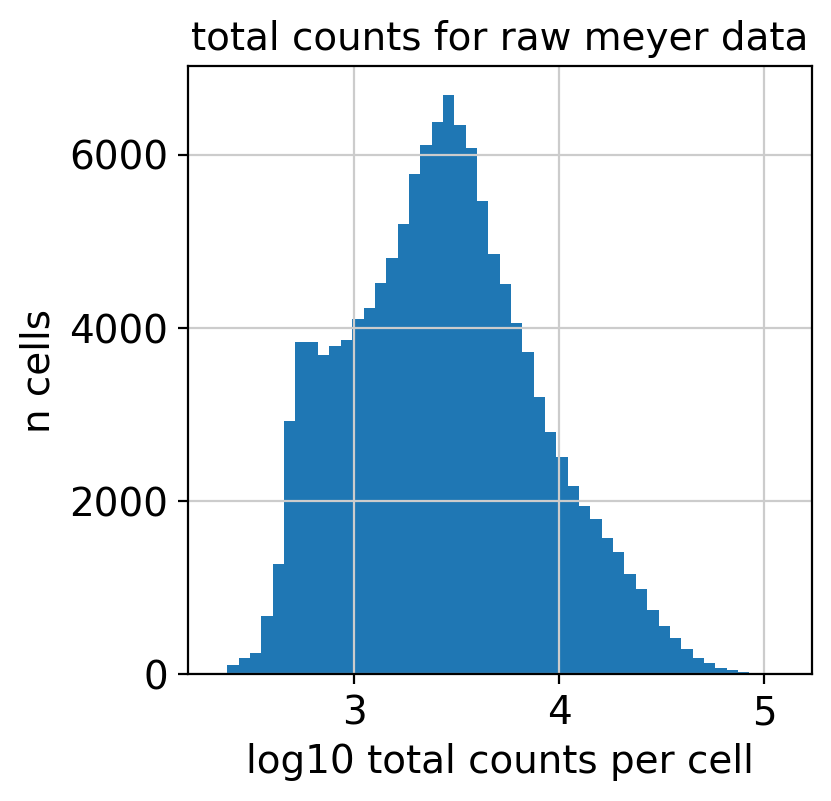

In [13]:
plt.hist(np.log10(total_counts_raw), bins=50)
plt.xlabel("log10 total counts per cell")
plt.ylabel("n cells")
plt.title("total counts for raw meyer data")
plt.show()

Set the adata core to its raw counts (we will use a simple total counts normalization for both the core and the meyer data for the downstream gene-based analysis to be consistent, SCRAN is too memory-expensive). Note that the integration is based on raw counts and will not be affected.

In [14]:
adata_core.X = adata_core.layers["counts"]

In [16]:
adata_core.X[:10, :10].toarray()

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  0.,  2.,  0.,  0.,  0.,  0.],
       [ 3.,  0.,  1.,  0.,  0.,  0.,  2.,  1., 29.,  1.],
       [ 0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

normalize to median total counts and log-transform:

In [28]:
median_tc = np.array(np.median(adata_core.X.sum(axis=1), axis=0))[0][0]

In [29]:
print("Median total counts in raw core data:", median_tc)

Median total counts in raw core data: 4461.0


In [30]:
sc.pp.normalize_per_cell(adata_core, counts_per_cell_after=median_tc)

delete scran size factors to prevent confusion:

In [31]:
del adata_core.obs["size_factors"]

log-transform:

In [32]:
sc.pp.log1p(adata_core)

normalize meyer data with a simple total counts normalization, and log-transform:

In [33]:
adata_meyer.layers["counts"] = adata_meyer.X

In [34]:
sc.pp.normalize_per_cell(adata_meyer, counts_per_cell_after=median_tc)

In [35]:
sc.pp.log1p(adata_meyer)

remove superfluous parts of adatas:

In [36]:
adata_meyer.var.drop(columns=adata_meyer.var.columns, inplace=True)

In [37]:
cols_core_to_remove = [
    col for col in adata_core.obs.columns if col.startswith("entropy")
] + ["ann_new", "original_ann_new"]

In [38]:
adata_core.obs.drop(columns=cols_core_to_remove, inplace=True)

In [39]:
obsm_cats_to_remove_core = list()
for obsm_cat in adata_core.obsm.keys():
    if obsm_cat != "X_scanvi_emb":
        obsm_cats_to_remove_core.append(obsm_cat)
for obsm_cat in obsm_cats_to_remove_core:
    del adata_core.obsm[obsm_cat]

In [40]:
del adata_core.layers["counts"]
del adata_core.obsp
del adata_core.varm
del adata_core.uns

In [41]:
var_cols_to_drop_core = [
    col
    for col in adata_core.var.columns
    if col not in ["gene_symbols", "highly_variable"]
]
adata_core.var.drop(columns=var_cols_to_drop_core, inplace=True)

In [42]:
del adata_meyer.layers["counts"]
del adata_meyer.uns

In [44]:
del adata_core.raw

concatenate adatas:

convert core to dtype float32, to correspond to meyer format:

In [45]:
adata_core.X = adata_core.X.astype(dtype="float32")

In [46]:
adata_core_meyer = sc.concat(
    adatas=(adata_core, adata_meyer), join="outer", index_unique=None
)

if ad.concat was used above: the concatenation causes some errors with storing when nans are combined with categoricals, we'll fix that as follows:

In [ ]:
# for obscol in adata_core_meyer.obs.columns:
#     if type(adata_core_meyer.obs[obscol].values) == "category":
#         adata_core_meyer.obs[obscol] = adata_core_meyer.obs[obscol].astype(str)
# for varcol in adata_core_meyer.var.columns:
#     if type(adata_core_meyer.var[varcol].values) == "category":
#         adata_core_meyer.var[varcol] = adata_core_meyer.var[varcol].astype(str)
# adata_core_meyer.X = np.nan_to_num(adata_core_meyer.X)

delete two original parts of concatenated data to save memory:

In [47]:
del adata_core
del adata_meyer

shuffle cell order (for plotting): (takes too much memory, so commented out)

In [ ]:
# index_list = adata_core_meyer.obs.index.tolist()
# np.random.shuffle(index_list)
# adata_core_meyer = adata_core_meyer[index_list, :]

add nested clustering:

In [ ]:
n_levels = 4

In [ ]:
for clustering_level in range(1, n_levels + 1):
    print("clustering level:", clustering_level, "...")
    if clustering_level == 1:
        # skip for re-run
        cluster_name = f"core_meyer_leiden_1"
        #         first clustering is not nested, so use normal function. Make sure your neighbors are based on embedding.
        sc.pp.neighbors(adata_core_meyer, use_rep="X_scanvi_emb", n_neighbors=30)
        sc.tl.leiden(adata_core_meyer, resolution=0.01, key_added=cluster_name)
        sc.tl.umap(adata_core_meyer)
    else:
        previous_clustering = f"core_meyer_leiden_" + str(clustering_level - 1)
        cluster_name = f"core_meyer_leiden_" + str(clustering_level)
        #         perform nested clustering
        #         set parameters:
        res = 0.2
        if clustering_level == 2:
            k = 30
            min_cluster_size = 50
        elif clustering_level == 3:
            k = 15
            min_cluster_size = 30
        elif clustering_level == 4:
            k = 10
            min_cluster_size = 10

        adata_core_meyer = nested_clustering.add_nested_clustering_blind(
            adata_core_meyer,
            previous_clustering,
            cluster_name,
            use_rep="X_scanvi_emb",
            cluster_alg="leiden",
            cluster_k=k,
            cluster_res=res,
            min_cluster_size=min_cluster_size,
            redo_pca=False,  # SET THIS TO FALSE FOR SCANVI!!! OR OTHER EMBEDDING-OUTPUT METHODS!!!!!
        )
        # plot
        sc.pl.umap(adata_core_meyer, color=cluster_name)

Add label transfer results to final object:

Check if all cells from the meyer data are present (with same barcode) in label transfer results:

In [ ]:
meyer_cells = adata_core_meyer.obs.loc[
    adata_core_meyer.obs.study == "Meyer_2021", :
].index.tolist()
label_tr_res.index.isin(adata_core_meyer.obs.index).sum() == len(meyer_cells)

now add columns:

In [ ]:
for col in label_tr_res.columns:
    adata_core_meyer.obs[col] = np.nan
    adata_core_meyer.obs.loc[meyer_cells, col] = label_tr_res.loc[meyer_cells, col]

and store:

In [ ]:
adata_core_meyer.write(path_output_core_meyer_adata)

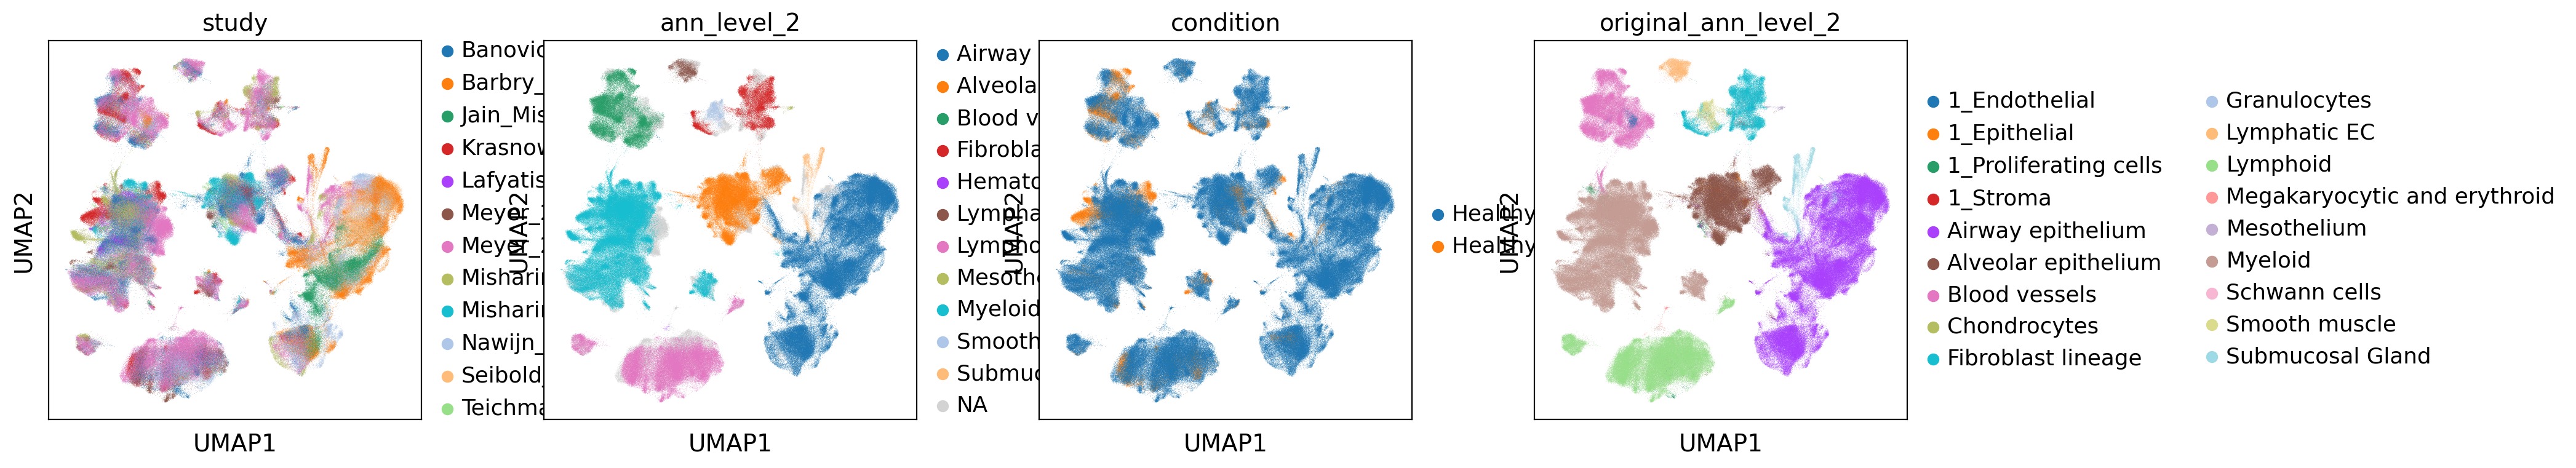

In [60]:
sc.pl.umap(
    adata_core_meyer,
    color=[
        "study",
        "ann_level_2",
        "condition",
        "original_ann_level_2",
    ],
)

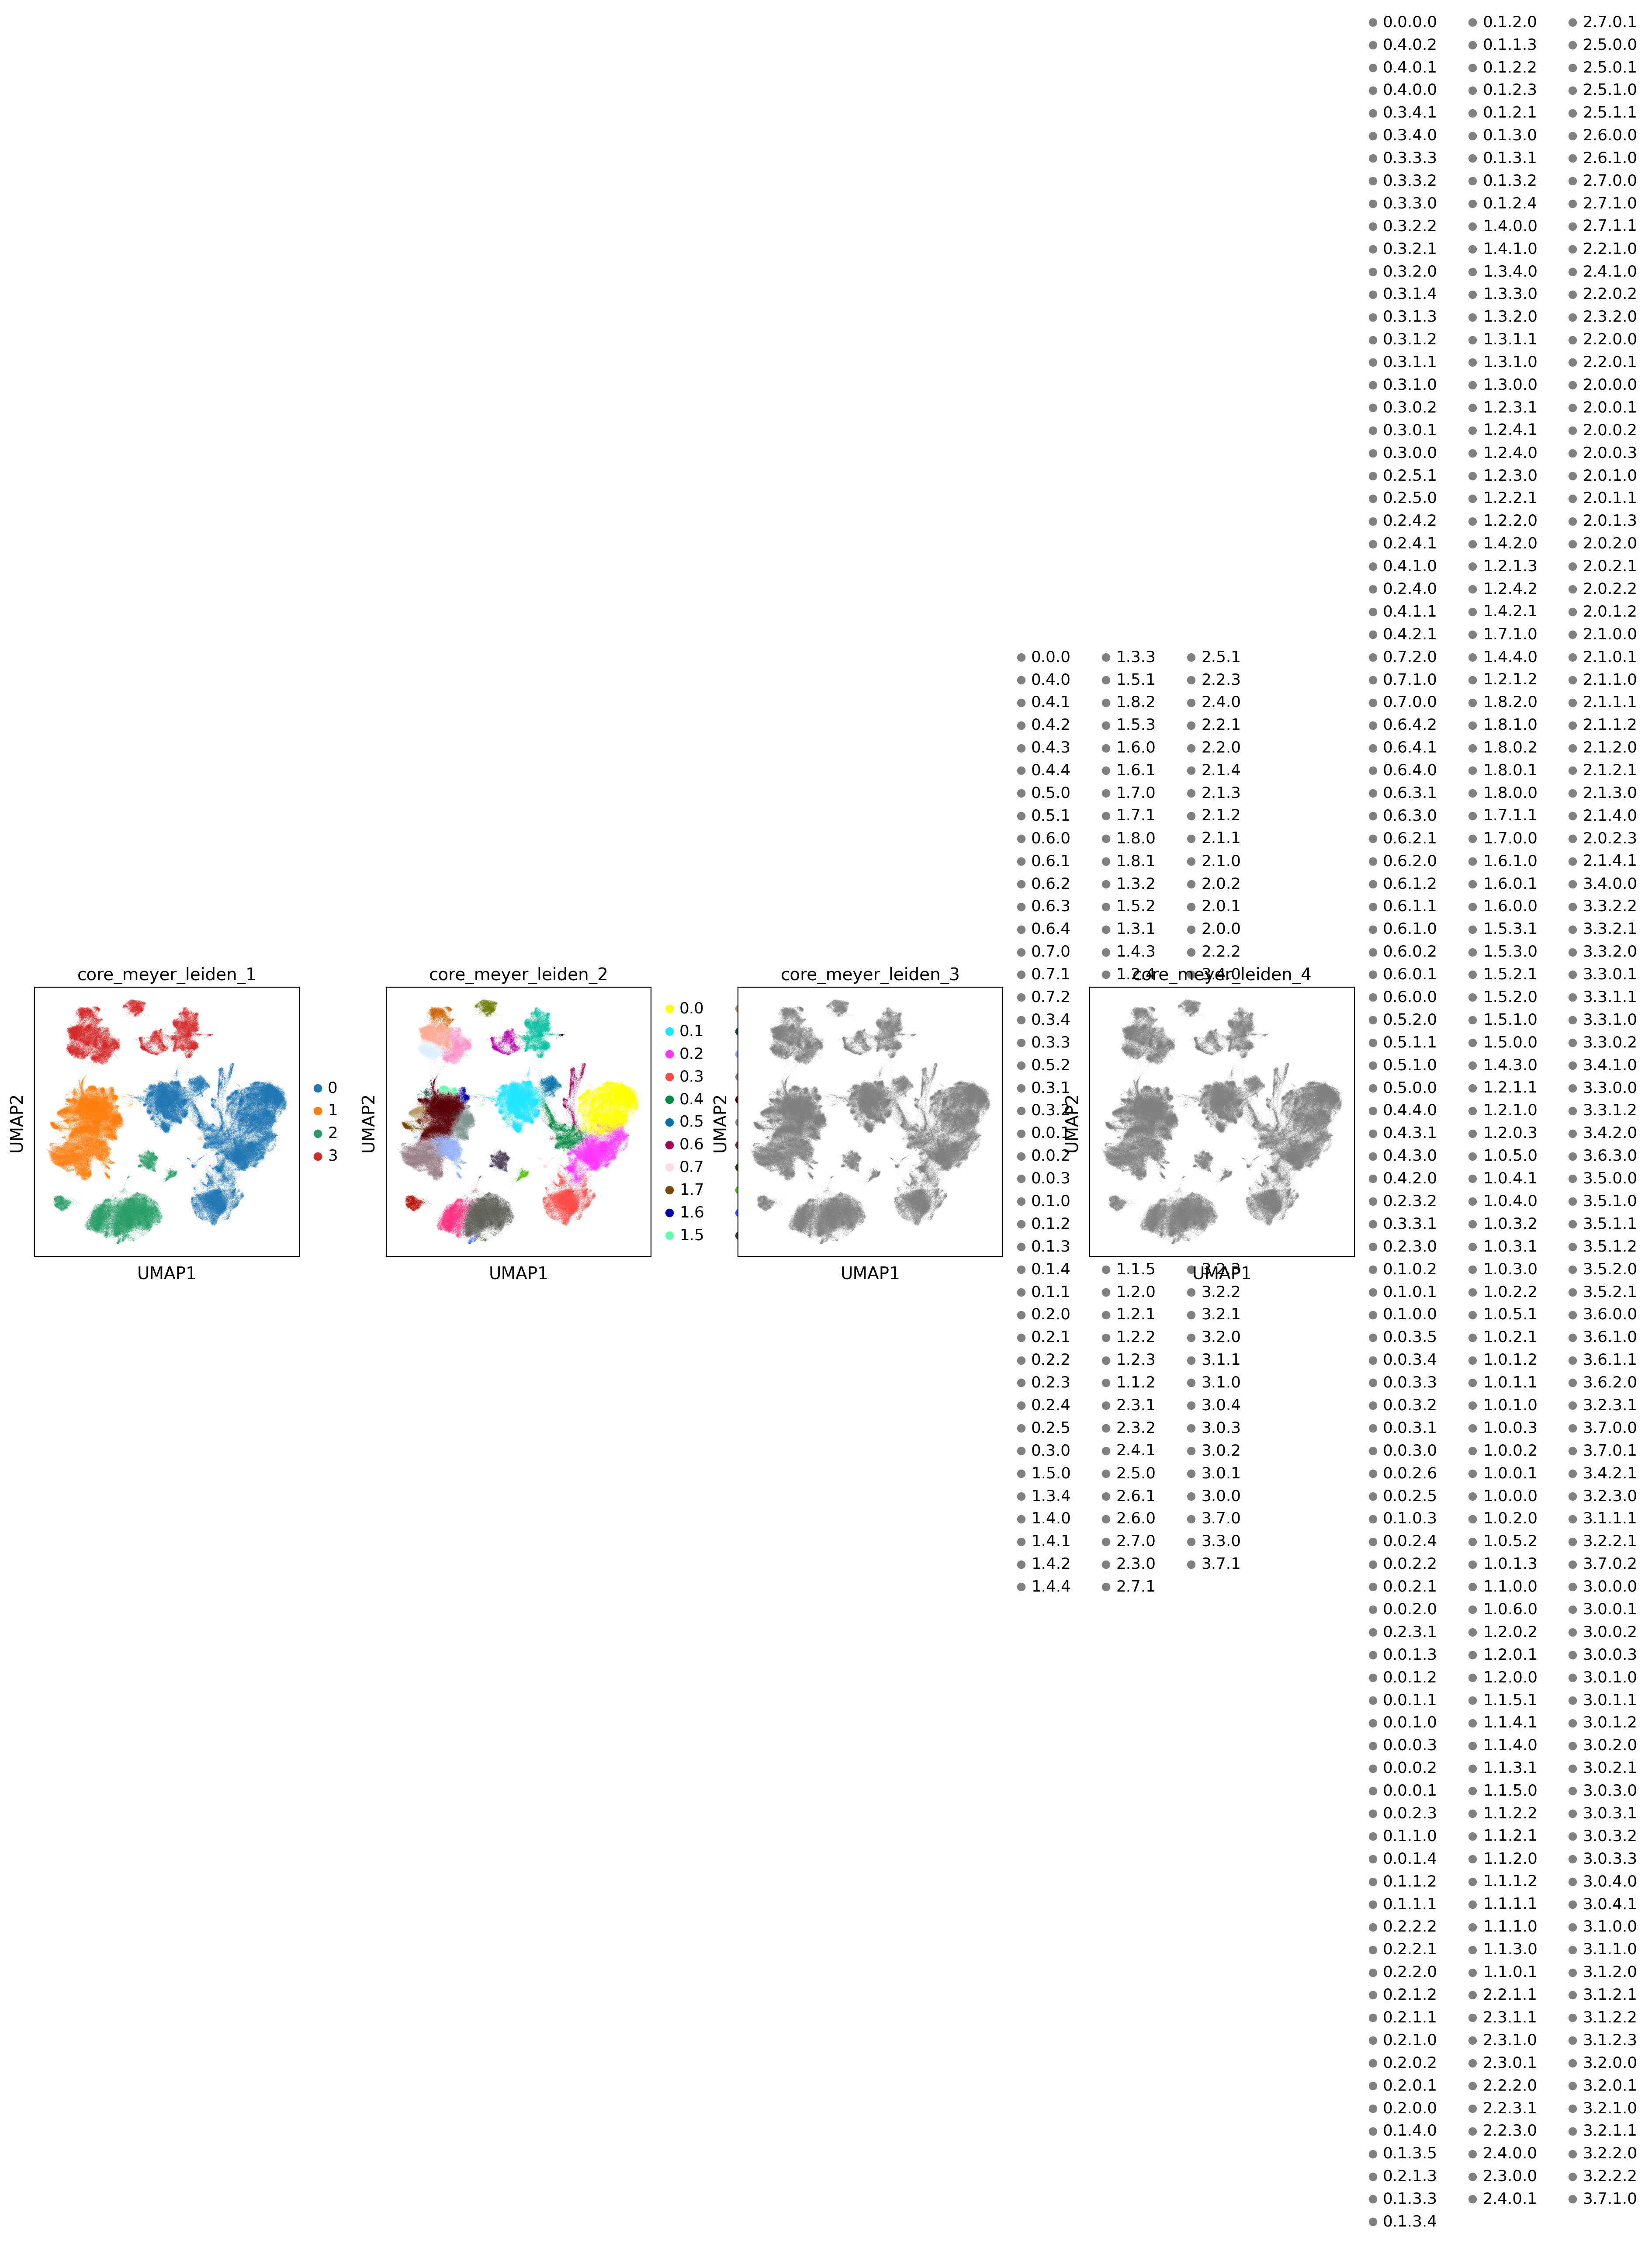

In [61]:
sc.pl.umap(
    adata_core_meyer_old,
    color=[
        "core_meyer_leiden_1",
        "core_meyer_leiden_2",
        "core_meyer_leiden_3",
        "core_meyer_leiden_4",
    ],
)